In [1]:
import os
import random
import pickle
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import shap
import xgboost as xgb
from scipy import stats
from zeo_amd.classify import train_classifier, get_datasets, get_metrics, get_best_classifier
from zeo_amd.plotting import savefig

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

xgb_file = "../data/xgb_ensembles.pkl"

In [3]:
X = dm.values
X_norm = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)

## Training classifiers

In [4]:
MIN_SYNTHESIS = 0.25
MIN_POSITIVE = 10
NUM_ROUNDS = 100

In [5]:
if not os.path.exists(xgb_file):
    ensemble = {}

    for _label in synth.columns:
        y = (synth[_label] > MIN_SYNTHESIS).values

        if y.sum() < MIN_POSITIVE:
            continue

        for n in range(NUM_ROUNDS):
            clf = get_best_classifier()

            X_train, X_test, y_train, y_test = get_datasets(
                X, y, test_size=0.1, balanced=True, random_seed=143,
            )

            clf.fit(X_train, y_train)

            ensemble[_label] = ensemble.get(_label, []) + [clf]

        with open(xgb_file, "wb") as f:
            pickle.dump(ensemble, f)

## Obtaining the SHAP values and feature importances

In [6]:
with open("../data/xgb_ensembles.pkl", "rb") as f:
    ensemble = pickle.load(f)

In [8]:
shap_vals = {}

for label, clf_list in ensemble.items():
    values = []
    for clf in clf_list:
        explainer = shap.TreeExplainer(clf)
        values.append(explainer.shap_values(X))
    
    values = np.stack(values).mean(0)
    shap_vals[label] = values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [9]:
correlations = {}

for label, vals in shap_vals.items():
    label_corrs = {}
    for i, code in enumerate(dm.index):
        x = X_norm[:, i]
        sh = vals[:, i]

        corr, pval = stats.pearsonr(x, sh)
        label_corrs[code] = corr

    correlations[label] = label_corrs

An input array is constant; the correlation coefficient is not defined.


## Highlighting the graph based on the feature importance

In [11]:
with open("../data/iza_mst_nx.pkl", "rb") as f:
    G = pickle.load(f)

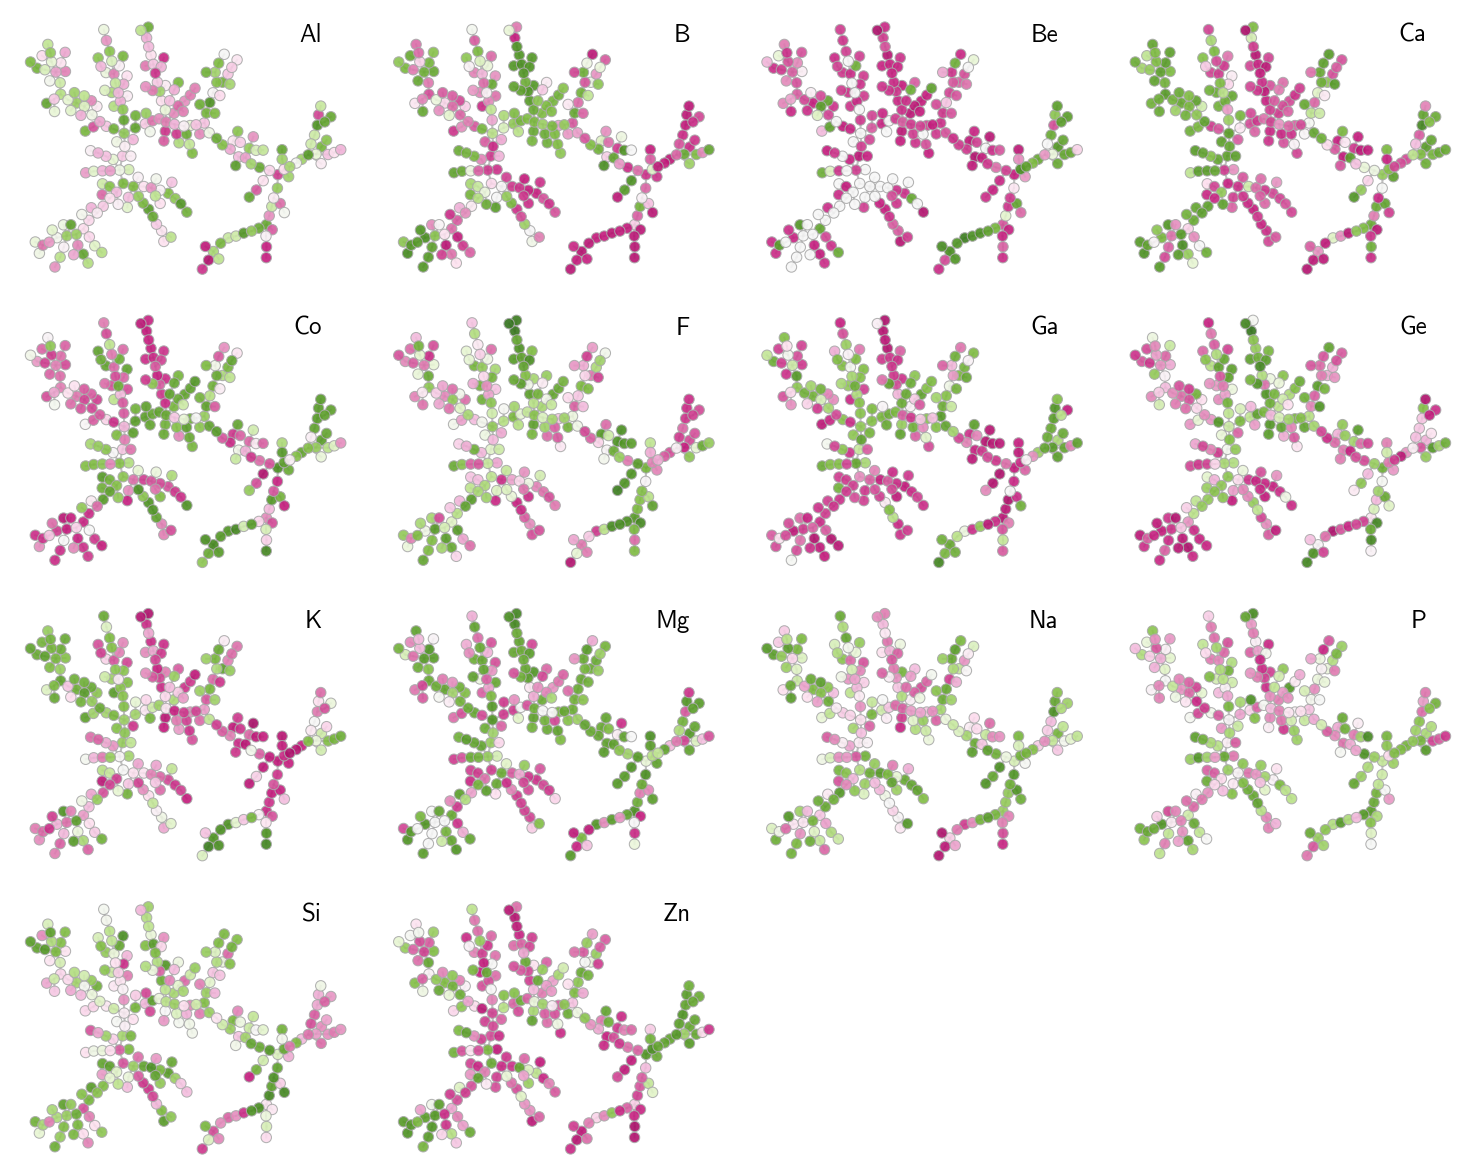

In [12]:
LX, LY = 2.5, 2.0
fig, ax_fig = plt.subplots(4, 4, figsize=(4 * LX, 4 * LY))

pos = nx.get_node_attributes(G, "pos")

options = {
    "edgecolors": "#aaaaaa00",
    "linewidths": 0.5,
    "node_size": 25,
    "alpha": 0.9,
    "cmap": "PiYG_r",
    "vmin": -1,
    "vmax": 1,
}

for ax, (label, corrs) in zip(ax_fig.reshape(-1), correlations.items()):
    node_color = np.array(list(corrs.values()))
    node_color[np.isnan(node_color)] = 0
    
    nx.draw_networkx_nodes(G, pos, node_color=node_color, ax=ax, **options)

    for i, j in G.edges:
        xy = np.stack([pos[i], pos[j]])
        ax.plot(xy[:, 0], xy[:, 1], linewidth=1.0, color="#808080", alpha=0.5, zorder=-1)
    
    ax.axis("off")
    ax.annotate(label, (0.9, 0.9), xycoords="axes fraction", ha="right", fontsize=12)

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")
    
plt.tight_layout()
savefig(fig, "05-classifier-explainabililty.pdf")
plt.show()

## Displaying the full SHAP values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


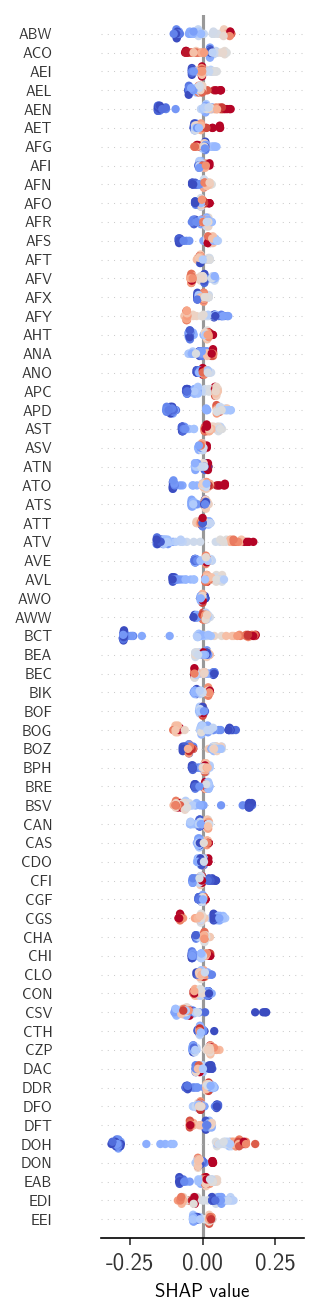

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


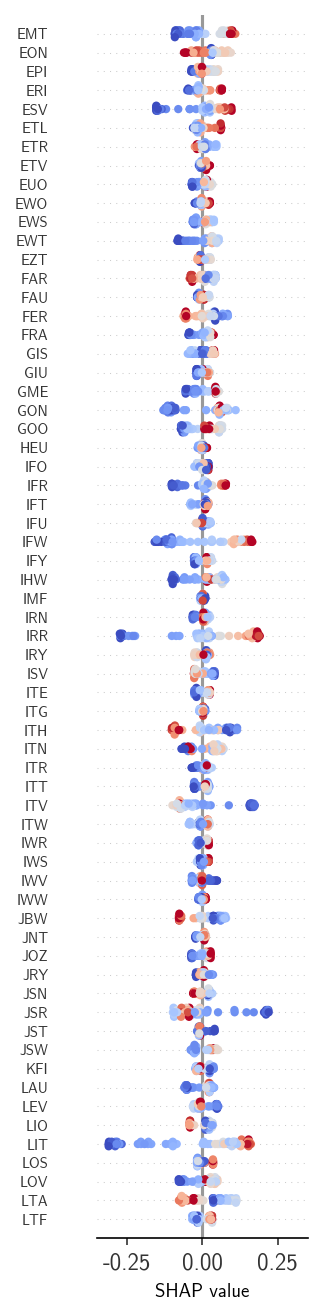

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


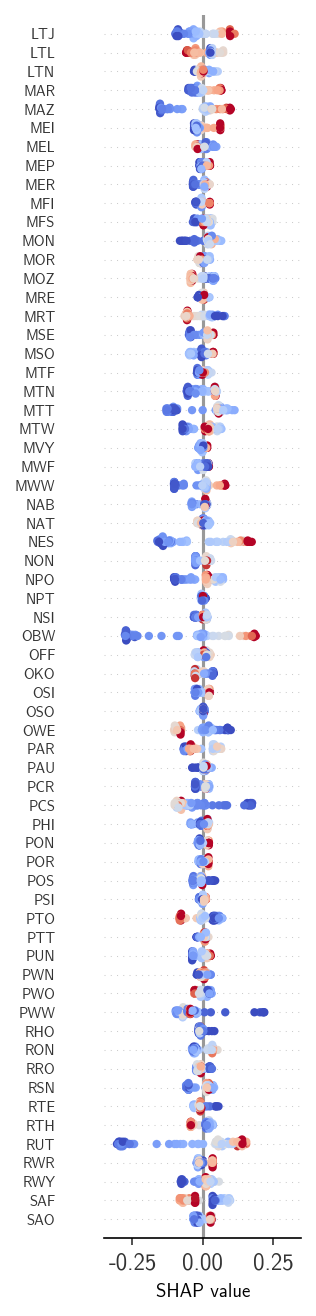

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


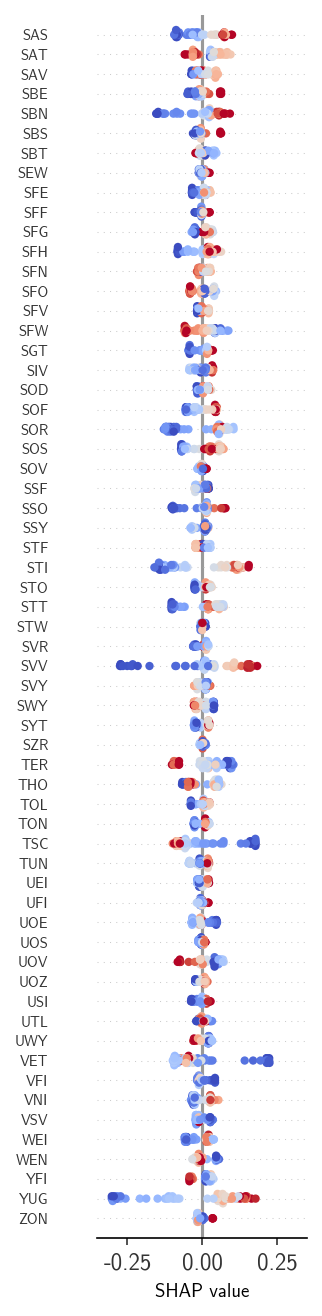

In [16]:
max_display = 64
label = "Ge"

for i in range(4):
    idx = slice(i * max_display, (i + 1) * max_display)

    vals = shap_vals[label][idx]
    feats = X_norm[idx]
    names = dm.index[idx]
    
    display = min(max_display, len(names))

    shap.summary_plot(
        vals,
        feats,
        feature_names=names,
        max_display=display,
        sort=False,
        cmap=cm.coolwarm,
        color_bar=False,
        plot_size=(2.5, 9),
        show=False,
    )
    fig = plt.gcf()
    ax = plt.gca()

    ax.set_xlabel("SHAP value", fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    ax.set_xlim(-0.35, 0.35)
    
    savefig(fig, f"05-classifier-shap-{label}-{i + 1}.pdf")
    plt.show()